In [2]:
import sys
import os

notebook_dir = os.getcwd()
sys.path.append(os.path.dirname(notebook_dir))
from CONNECT_TO_DB import setup_connection
import matplotlib.pyplot as plt
import psycopg2

2025-06-06 22:11:06 INFO: Generating boxplot for item prices.


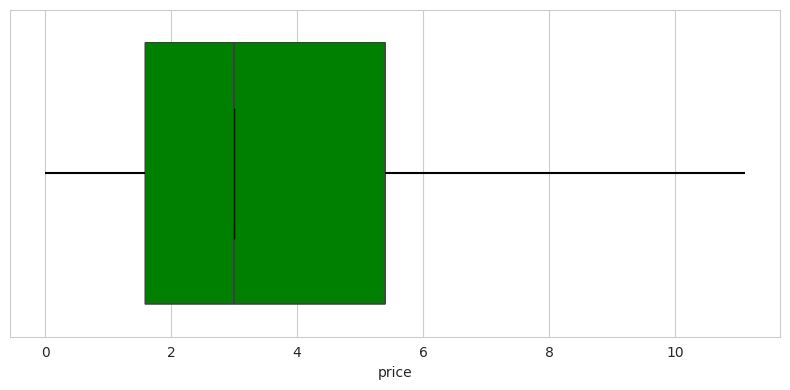

In [8]:
def boxplot_item_prices():
    """Generate horizontal boxplot for item prices - matches your first image"""
    logging.info("Generating boxplot for item prices.")
    try:
        conn = setup_connection()
        cur = conn.cursor()
        cur.execute("SELECT price FROM customers WHERE price IS NOT NULL AND event_type = 'purchase';")
        prices = [float(row[0]) for row in cur.fetchall()]
        cur.close()
        conn.close()
    except Exception as e:
        logging.error(f"Database error: {e}")
        return

    if not prices:
        logging.warning("No prices found.")
        print("No prices found.")
        return

    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 4))
    ax = sns.boxplot(
        x=prices,
        showcaps=False,
        boxprops={'facecolor': 'green'},
        showfliers=False,
        whiskerprops={'color': 'black', 'linewidth': 1.5},
        medianprops={'color': 'black'},
        notch=True  # Pass notch here
    )
    ax.set_xlabel('price')
    ax.set_ylabel('')
    ax.set_title('')
    plt.tight_layout()
    plt.show()  # Show plot in notebook

boxplot_item_prices()

2025-06-06 22:12:04 INFO: Generating horizontal green boxplot for item prices (axes swapped).


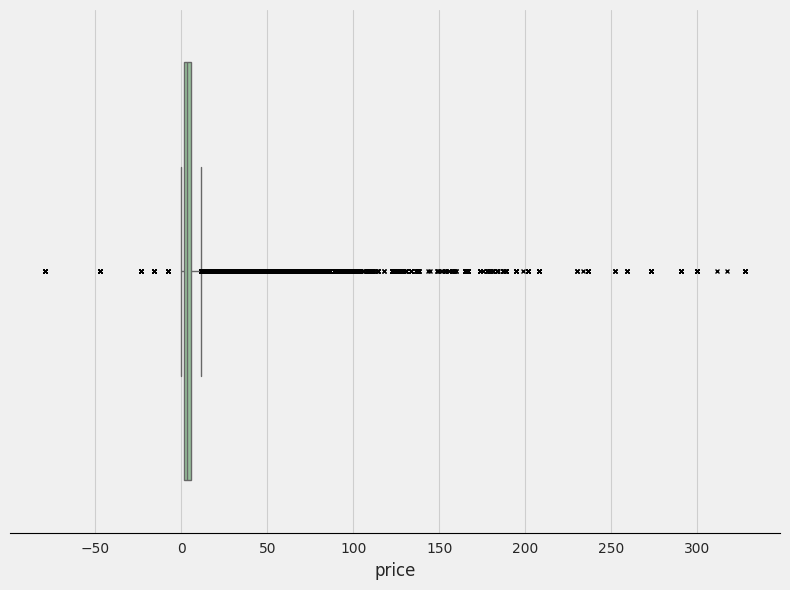

In [9]:
def boxplot_item_prices_vertical_green():
    """Generate horizontal green boxplot for item prices (axes swapped)"""
    logging.info("Generating horizontal green boxplot for item prices (axes swapped).")
    try:
        conn = setup_connection()
        cur = conn.cursor()
        cur.execute("SELECT price FROM customers WHERE price IS NOT NULL AND event_type = 'purchase';")
        prices = [float(row[0]) for row in cur.fetchall()]
        cur.close()
        conn.close()
    except Exception as e:
        logging.error(f"Database error: {e}")
        return

    if not prices:
        logging.warning("No prices found.")
        print("No prices found.")
        return

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('#f0f0f0')
    ax.set_facecolor('#f0f0f0')
    sns.boxplot(
        x=prices,
        color='#90c695',
        linewidth=1,
        fliersize=3,
        flierprops={'marker': 'x', 'markerfacecolor': 'black', 'markeredgecolor': 'black'},
        ax=ax
    )
    ax.set_xlabel('price', fontsize=12)
    ax.set_ylabel('')
    ax.set_title('')
    ax.grid(True, alpha=0.3, color='gray')
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    plt.tight_layout()
    plt.show()

boxplot_item_prices_vertical_green()


2025-06-06 22:16:07 INFO: Generating boxplot for average basket per user (0 <= price <= 42, blue box, outliers as 'X', notched whiskers).


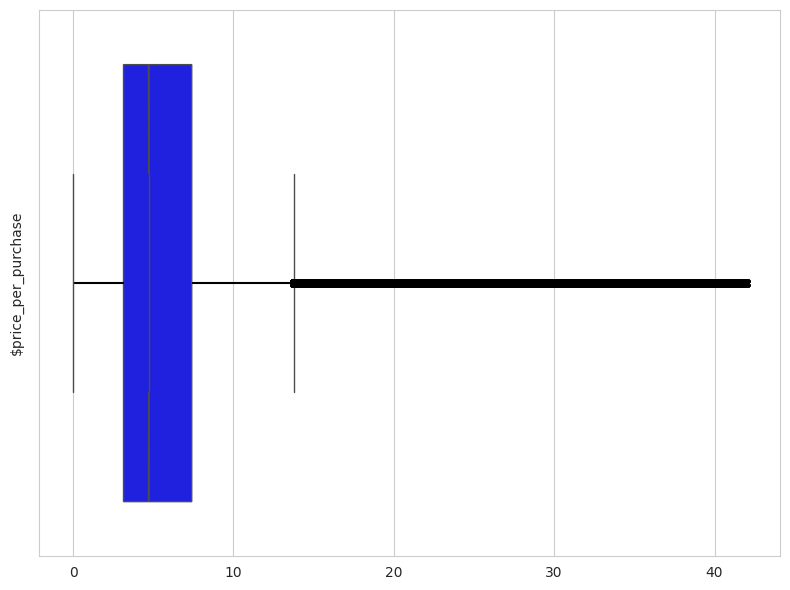

In [16]:
def calculate_basket_average():
    """
    Returns a DataFrame with price_per_purchase per user_session, using the plan described.
    Only sessions with nonzero basket value and at least one purchase are included.
    """
    try:
        conn = setup_connection()
        cur = conn.cursor()
        cur.execute("""
            SELECT 
                user_session, 
                user_id,
                MIN(event_time) AS first_event,
                MAX(event_time) AS last_event,
                COUNT(*) AS event_count,
                SUM(CASE WHEN event_type NOT IN ('view', 'remove_from_cart') THEN price ELSE 0 END) AS price_total,
                SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END) AS price_subtract,
                SUM(CASE WHEN event_type NOT IN ('view', 'remove_from_cart') THEN price ELSE 0 END) - SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END) AS basket_session,
                SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_per_session,
                CASE 
                    WHEN SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) > 0 THEN TRUE 
                    ELSE FALSE 
                END AS has_purchase,
                CASE 
                    WHEN SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) = 0 THEN 0
                    ELSE 
                        (SUM(CASE WHEN event_type != 'view' THEN price ELSE 0 END) - SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END)) 
                        / NULLIF(SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END), 0)
                END AS price_per_purchase
            FROM public.customers 
            WHERE user_session != '00000000-0000-0000-0000-000000000000' AND event_type = 'purchase'
            GROUP BY user_session, user_id
            HAVING SUM(CASE WHEN event_type != 'view' THEN price ELSE 0 END) - SUM(CASE WHEN event_type = 'remove_from_cart' THEN price ELSE 0 END) != 0
            AND SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) > 0
            ORDER BY MIN(event_time);
        """)
        columns = [desc[0] for desc in cur.description]
        rows = cur.fetchall()
        cur.close()
        conn.close()
        df = pd.DataFrame(rows, columns=columns)
        return df
    except Exception as e:
        logging.error(f"Database error in calculate_basket_average: {e}")
        return pd.DataFrame()
        
# PLOT 3
def boxplot_avg_basket_per_user(column):
    """Boxplot for ${column} from calculate_basket_average (vertical, blue, outliers as 'X', upper limit 42, no outliers < 0)"""
    logging.info("Generating boxplot for average basket per user (0 <= price <= 42, blue box, outliers as 'X', notched whiskers).")
    df = calculate_basket_average()
    if df.empty or column not in df:
        logging.warning(f"No data for ${column}.")
        return

    # Filter to keep only 0 <= value <= 42
    filtered = df[(df[column] >= 0) & (df[column] <= 42)]
    if filtered.empty:
        logging.warning(f"No data for 0 <= ${column} <= 42.")
        return

    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        x=filtered[column],
        color='blue',
        showfliers=True,
        notch=True,
        flierprops={'marker': 'X', 'markerfacecolor': 'black', 'markeredgecolor': 'black'},
        whiskerprops={'color': 'black', 'linewidth': 1.5}
    )
    ax.set_ylabel(f'${column}')
    ax.set_xlabel('')
    ax.set_title('')
    plt.tight_layout()
    plt.show()

boxplot_avg_basket_per_user('price_per_purchase')
